In [247]:
import torch
import random
import matplotlib.pyplot as plt

from torch import tensor
from torch.nn.functional import interpolate, pad
from torchaudio import transforms
from datasets import DatasetDict
from transformers import ASTFeatureExtractor

In [2]:
preprocessed_dataset = DatasetDict.load_from_disk("../dataset/music_lib")
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 16378
    })
    validate: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 2342
    })
    test: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 4675
    })
})

In [200]:
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)

model_input_name = feature_extractor.model_input_names[0]
labels_name = "labels"
paths_name = "paths"

In [519]:
def visualize_spectrum(specs, size=(10,6), cols=1, rows=1):
    plt.figure(figsize=size)
    for idx, spec in enumerate(specs):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(spec.T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label="Amplitude")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bins")
        plt.tight_layout()
    plt.tight_layout()
    plt.show()

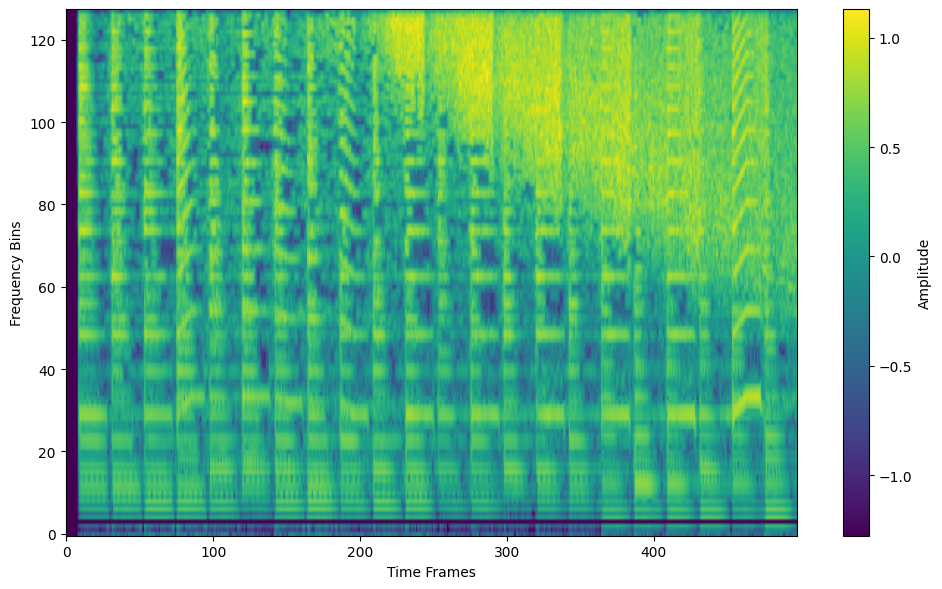

In [319]:
test_spec = tensor(preprocessed_dataset["train"][0][model_input_name])
visualize_spectrum(test_spec)

In [515]:
class SpecAugmentPipeline:
    def __init__(
            self,
            p=0.5,
            effects_p=0.5,
            time_mask_param=30,
            freq_mask_param=20,
            noise_level=0.05,
            stretch_range=(0.8, 1.2),
            shift_range=3,
            amplitude_range=(0.8, 1.2)
    ):
        self.p = p
        self.effects_p = effects_p
        self.time_mask = transforms.TimeMasking(time_mask_param)
        self.freq_mask = transforms.FrequencyMasking(freq_mask_param)
        self.noise_level = noise_level
        self.stretch_range = stretch_range
        self.shift_range = shift_range
        self.amplitude_range = amplitude_range

    def add_noise(self, spec):
        return spec + torch.randn_like(spec) * self.noise_level
    
    def time_stretch(self, spec):
        spec = spec.unsqueeze(0)
        factor = random.uniform(*self.stretch_range)
        new_steps = int(spec.size(-1) * factor)
        new_spec = interpolate(spec, (spec.size(-2), new_steps), mode="bilinear", align_corners=False).squeeze(0)
        return new_spec[:, :spec.size(-1)] if factor >= 1 else pad(new_spec, (0, spec.size(-1) - new_steps))

    def frequency_shift(self, spec):
        shift = random.randint(-self.shift_range, self.shift_range)
        return torch.roll(spec, shifts=shift, dims=-2)

    def amplitude_scaling(self, spec):
        return spec * random.uniform(*self.amplitude_range)

    def __call__(self, spec):
        if random.random() >= self.p:
            return spec
        
        spec = spec.transpose(-1, -2)
        if random.random() < self.effects_p:
            spec = self.time_mask(spec)
        
        if random.random() < self.effects_p:
            spec = self.freq_mask(spec)

        if random.random() < self.effects_p:
            spec = self.add_noise(spec)

        if random.random() < self.effects_p:
            spec = self.time_stretch(spec)

        if random.random() < self.effects_p:
            spec = self.frequency_shift(spec)

        if random.random() < self.effects_p:
            spec = self.amplitude_scaling(spec)

        return spec.transpose(-1, -2)

In [516]:
aug_pipe = SpecAugmentPipeline(p=0.5)

original


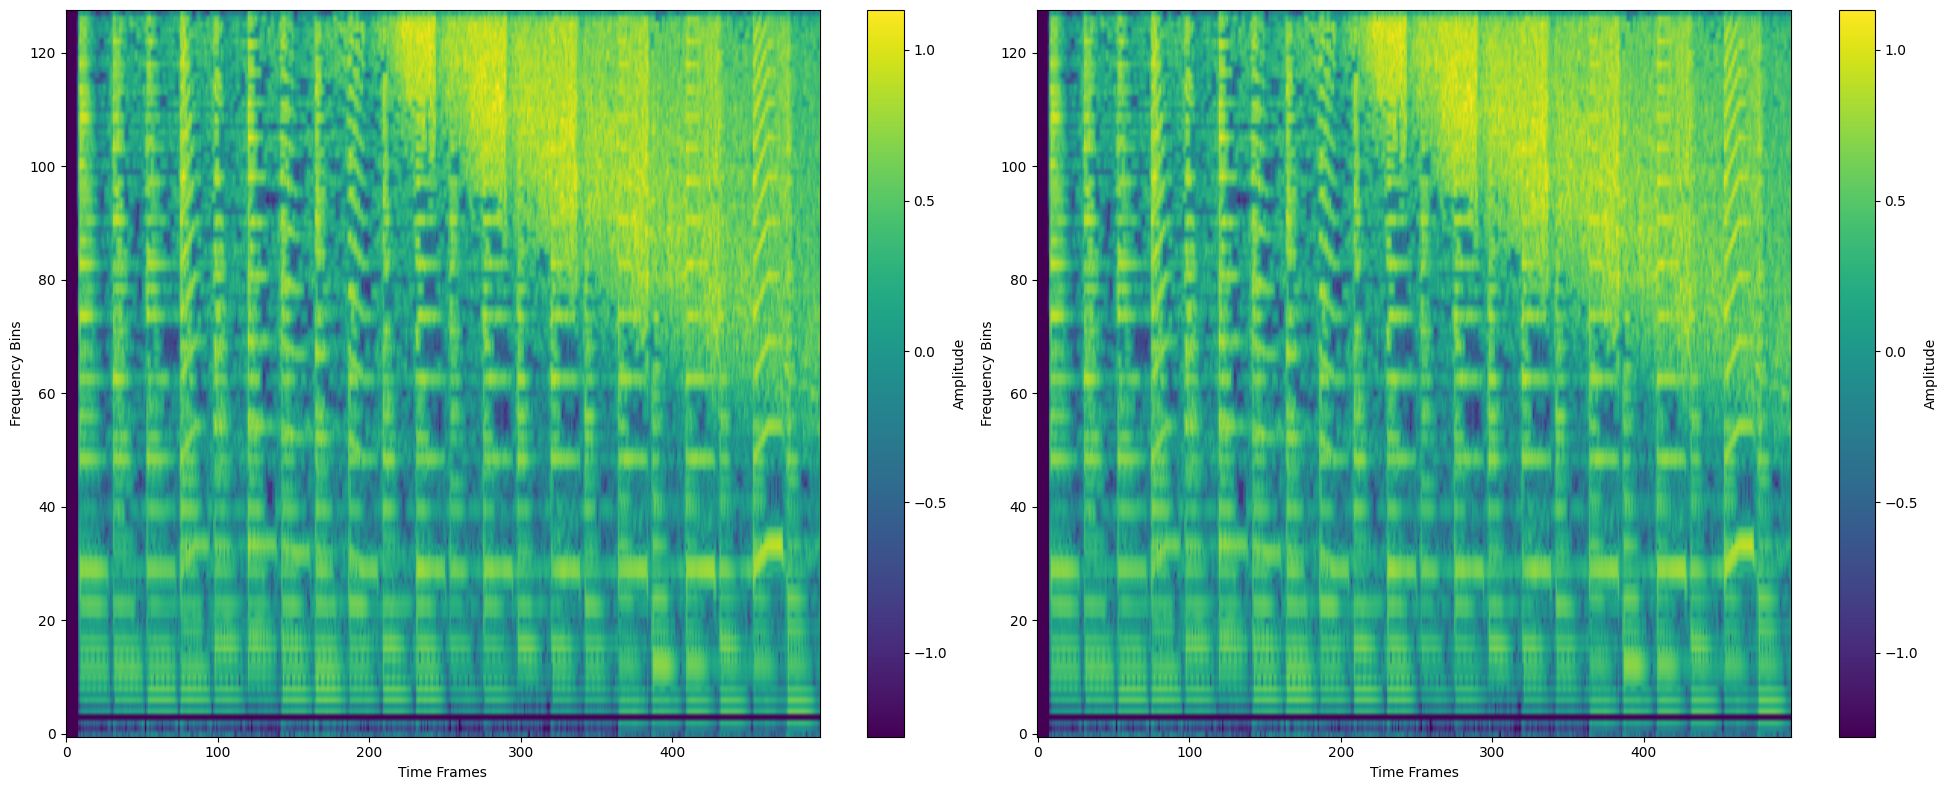

In [503]:
visualize_spectrum(test_spec, aug_pipe(test_spec), size=(20, 8), cols=2)

In [517]:
def augmentation(sample):
    return {
        model_input_name: aug_pipe(tensor(sample[model_input_name])),
        labels_name: sample[labels_name],
        paths_name: sample[paths_name] 
    }

preprocessed_dataset["train"].set_transform(augmentation)

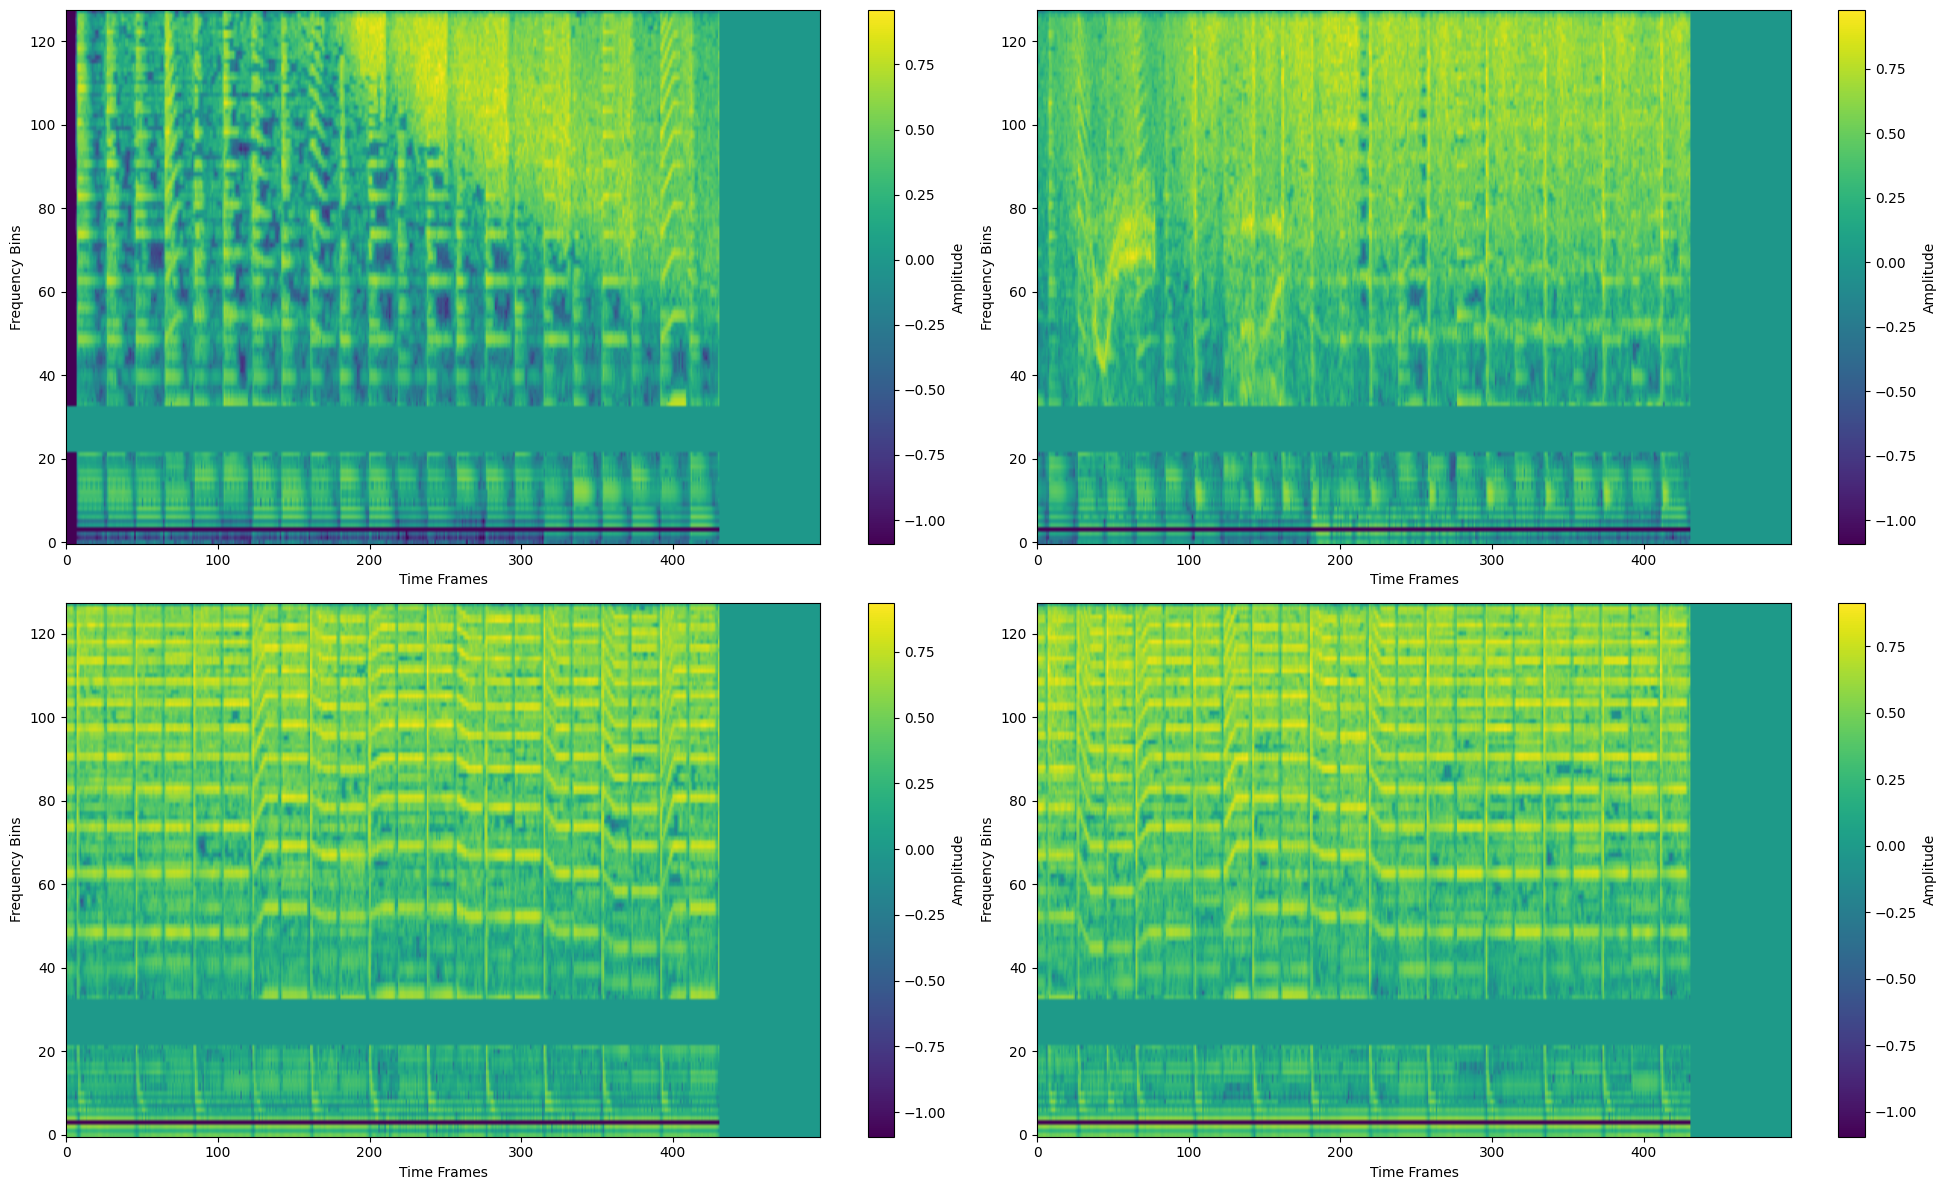

In [536]:
augmented_spec = preprocessed_dataset["train"][0:4][model_input_name]
visualize_spectrum(augmented_spec, cols=2, rows=2, size=(20, 12))